In [8]:
import networkx as nx
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.animation as animation
%matplotlib notebook

class RicciFlowWidget:
    def __init__(self, G, pos, epsilon=0.1):
        self.G = G
        self.pos = pos
        self.epsilon = epsilon
        self.num_nodes = G.number_of_nodes()

        self.edge_resistance = {}
        self.edge_curvature = {}
        # self.node_weights = np.array(
        #     [1 for v in G.nodes()]
        # )
        self.edge_weights = np.array(
            [1 for _ in G.edges()]
        )
        self.iter_count = 1
        """distance matrix"""
        # dists = dict(nx.all_pairs_shortest_path_length(G))
        # self.D = np.array(
        #     [[dists[v][u] for u in G.nodes()] for v in G.nodes()]
        # )
        self.compute_resistance_curvature()
        # add resistance attribute to edges
        for e in G.edges():
            self.edge_resistance[e] = self.Omega[e[0], e[1]]
            self.edge_curvature[e] = (
                1 / G.degree[e[0]] + 1 / G.degree[e[1]] 
                - self.edge_resistance[e] / G.edges[e[0], e[1]]["length"]
            )
            # add curvature attribute to edges
            G.edges[e[0], e[1]]["resistance"] = self.Omega[e[0], e[1]]
            G.edges[e[0], e[1]]["curvature"] = self.edge_curvature[e]

        self.ax = None
        self.drawn_nodes = None
        self.drawn_labels = None
        self.cmap = plt.cm.bwr
        # self.norm = TwoSlopeNorm(vcenter=0.0, vmin=-4, vmax=3)

    def compute_resistance_curvature(self):
        """resistance matrix"""
        G = self.G
        n = self.num_nodes
        self.L = nx.laplacian_matrix(G, weight="weight").toarray()
        res_matrix = np.zeros((n, n))
        for u in G.nodes():
            for v in G.nodes():
                if u == v:
                    res_matrix[u][v] = 0
                else:
                    res_matrix[u][v] = nx.resistance_distance(
                        G, u, v, weight="length")
        self.Omega = np.array(
            res_matrix
        )
        self.two_tau = 1/2 * np.matmul(
            self.Omega, np.matmul(self.L, self.Omega))[0, 0]
        # "kappa" is node curvature
        self.kappa = np.matmul(
            np.linalg.inv(self.Omega), np.ones((n, 1)) * self.two_tau)
        # node_weights = "resistance curvature" after Derviendt and Lambiotte
        self.node_weights = self.kappa.flatten()

    def animate(self):
        G = self.G
        fig, ax = plt.subplots()
        self.ax = ax
        fig.set_size_inches(8, 8)
        
        e_label_dict = {
            e: np.around(G.edges[e[0], e[1]]["length"], decimals=2) 
            for e in G.edges()
        }
        # Draw graph
        pos = nx.spring_layout(G, seed=1)
        self.drawn_nodes = nx.draw_networkx_nodes(
            G, pos, ax=self.ax, 
            node_color=[-self.node_weights[v] for v in G.nodes()], 
            cmap=self.cmap,
            vmin=-0.5,
            vmax=0.5)
        #draw edges and colored edges
        self.drawn_edges_color = nx.draw_networkx_edges(
            G, pos, ax=self.ax,
            width=6,
            edge_color=[-self.edge_curvature[e] for e in G.edges()],
            edge_cmap=self.cmap,
            edge_vmin=-0.5,
            edge_vmax=0.5
        )
        self.drawn_edges = nx.draw_networkx_edges(
            G, pos, ax=self.ax,
        )
        # drawn_labels is a dict whose values are ax.text() objects
        # self.drawn_labels = nx.draw_networkx_labels(
        #     G, pos, ax=self.ax, labels=n_labels)
        # draw edge weights over edges
        self.edge_labels = nx.draw_networkx_edge_labels(
            G, pos, 
            ax=self.ax, 
            edge_labels=e_label_dict
        )
        # show iteration count
        props = dict(alpha=0.5)
        self.count_box = ax.text(
            0.05, -0.07, 
            f"Iteration: {self.iter_count}", 
            transform=ax.transAxes, 
            fontsize=14,
            verticalalignment='top', 
            bbox=props)
        
        ani = animation.FuncAnimation(
            fig, self.animate_next, interval=30, save_count=30
        )
        plt.show()
        

    def draw(self):
        G = self.G
        fig, ax = plt.subplots()
        self.ax = ax
        fig.set_size_inches(8, 8)
        fig.subplots_adjust(right=0.85)
        # Create a `matplotlib.widgets.Button` to increment
        ax_button = fig.add_axes([0.6, 0.025, 0.3, 0.04])
        self.button = Button(
            ax_button, 'Increment', hovercolor='0.975')
        # Make graph options
        n_labels = {
            v : str(np.around(self.node_weights[v], decimals=2)) + "\n\n" 
            for v in G.nodes()
        }
        e_label_dict = {
            e: np.around(G.edges[e[0], e[1]]["length"], decimals=2) 
            for e in G.edges()
        }
        # Draw graph
        pos = nx.spring_layout(G, seed=1)
        self.drawn_nodes = nx.draw_networkx_nodes(
            G, pos, ax=self.ax, 
            node_color=[-self.node_weights[v] for v in G.nodes()], 
            cmap=self.cmap,
            vmin=-0.5,
            vmax=0.5)
        #draw edges and colored edges
        self.drawn_edges_color = nx.draw_networkx_edges(
            G, pos, ax=self.ax,
            width=6,
            edge_color=[-self.edge_curvature[e] for e in G.edges()],
            edge_cmap=self.cmap,
            edge_vmin=-0.5,
            edge_vmax=0.5
        )
        self.drawn_edges = nx.draw_networkx_edges(
            G, pos, ax=self.ax,
        )
        # drawn_labels is a dict whose values are ax.text() objects
        # self.drawn_labels = nx.draw_networkx_labels(
        #     G, pos, ax=self.ax, labels=n_labels)
        # draw edge weights over edges
        self.edge_labels = nx.draw_networkx_edge_labels(
            G, pos, 
            ax=self.ax, 
            edge_labels=e_label_dict
        )
        # show iteration count
        props = dict(alpha=0.5)
        self.count_box = ax.text(
            0.05, -0.07, 
            f"Iteration: {self.iter_count}", 
            transform=ax.transAxes, 
            fontsize=14,
            verticalalignment='top', 
            bbox=props)

    def animate_next(self, i):
        self.on_press(None)
        self.draw_update()
        print("i=", i)
        print("self.iter_count=", self.iter_count)

        time.sleep(0.2)

    def draw_update(self):
        G = self.G
        # update labels to reflect changed length
        n_label_dict = {
            v : np.around(self.node_weights[v], decimals=2)
            for v in G.nodes()
        }
        # for v in G.nodes():
        #     t = self.drawn_labels[v]
        #     t.set_text(str(n_label_dict[v]) + "\n\n" )
        e_label_dict = {
            e: np.around(G.edges[e[0], e[1]]["length"], decimals=2) 
            for e in G.edges()
        }
        for e in G.edges():
            t = self.edge_labels[e]
            t.set_text(str(e_label_dict[e]))
        # update layout
        pos = nx.spring_layout(G, seed=1)
        self.drawn_nodes.set_offsets(
            [list(x) for x in pos.values()]
        )
        # for v in G.nodes():
        #     t = self.drawn_labels[v]
        #     t.set_position(pos[v])
        self.drawn_edges_color.set_segments(
            [[pos[e[0]], pos[e[1]]] for e in G.edges()]
        )
        self.drawn_edges.set_segments(
            [[pos[e[0]], pos[e[1]]] for e in G.edges()]
        )
        for e in G.edges():
            t = self.edge_labels[e]
            x1, y1 = pos[e[0]]
            x2, y2 = pos[e[1]]
            avg_pos = [0.5 * (x1 + x2), 0.5 * (y1 + y2)]
            t.set_position(avg_pos)
            # `angle` computation taken from networkx source code
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            t.set_rotation(angle)       
        # nx.draw_networkx_edges(G, pos, ax=self.ax)
        # drawn_labels is a dict whose values are ax.text() objects
        '''update node colors''' 
        
        self.count_box.set_text(f"Iteration: {self.iter_count}")
        self.ax.set_xlim(
            -0.2 + min(pos[v][0] for v in G.nodes()), 
            0.2 + max(pos[v][0] for v in G.nodes())
        )
        self.ax.set_ylim(
            -0.2 + min(pos[v][1] for v in G.nodes()), 
            0.2 + max(pos[v][1] for v in G.nodes())
        )
        self.ax.figure.canvas.draw()

    def connect(self):
        """Connect to all the events we need."""
        self.cidbutton = self.button.on_clicked(self.on_press)

    def on_press_animate(self):
        self.on_press(None)

    def on_press(self, event):
        G = self.G
        # update lengths according to Ricci flow
        self.iter_count += 1
        print("button pressed; count=", self.iter_count)
        # compute gradient using curvature, update length 
        for e in G.edges():
            curv = G.edges[e[0], e[1]]["curvature"]
            new_length = G.edges[e[0], e[1]]["length"]
            new_length += - self.epsilon * curv
            if new_length < 0.01:
                new_length = 0.01
            # new_length += - self.epsilon * curv * length
            G.edges[e[0], e[1]]["length"] = new_length
            G.edges[e[0], e[1]]["weight"] = 1 / new_length
        self.compute_resistance_curvature()

        # update labels to reflect changed curvature
        self.draw_update()

    def disconnect(self):
        """Disconnect all callbacks."""


<IPython.core.display.Javascript object>


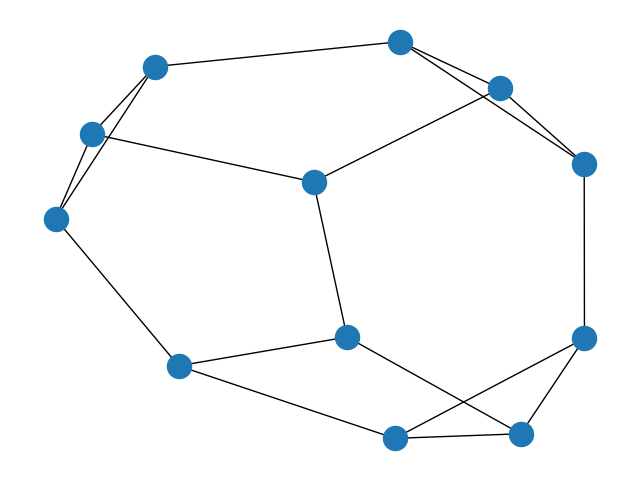

In [13]:
#################################
#
# CHOOSE YOUR GRAPH HERE
#
#################################
# G = nx.path_graph(6)
# G = nx.cycle_graph(7)
# G = nx.grid_graph([4,4])
G = nx.frucht_graph()
# G = nx.bull_graph()

# change node names to integers
mapping = {e : i for i, e in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
for (i, e) in enumerate(G.edges()):
    G.edges[e[0], e[1]]["length"] = 1
    G.edges[e[0], e[1]]["weight"] = 1

pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos)
plt.show()

<IPython.core.display.Javascript object>


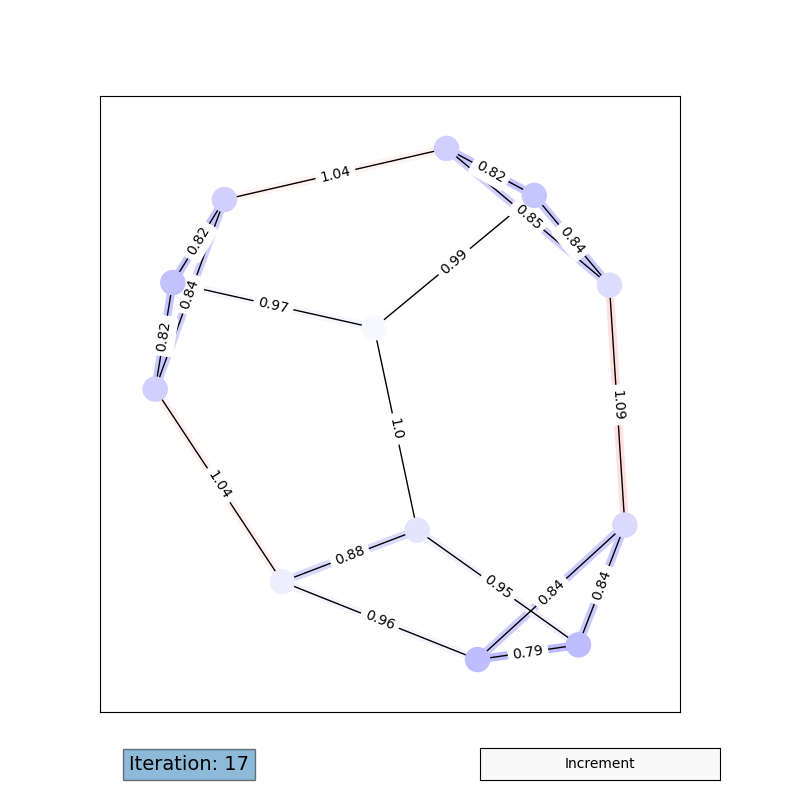

In [14]:
#################################
#
# VIEW RICCI FLOW HERE
#
#################################
widget = RicciFlowWidget(G, pos)

widget.draw()
widget.connect()
plt.show()
